**기본 세팅**

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rc('font', family='NanumGothic') # 폰트 설정
mpl.rc('axes', unicode_minus=False) # 유니코드에서 음수 부호 설정

# 차트 스타일 설정
sns.set(font="NanumGothic", rc={"axes.unicode_minus":False}, style='darkgrid')
plt.rc("figure", figsize=(10,8))

warnings.filterwarnings("ignore")

---

# 2. 군집 평가

군집화는 분류와 유사해보이지만 성격이 많이 다르다.

- 데이터 내에 숨어있는 별도의 그룹을 찾아서 의미를 부여한다.


- 동일한 분류 값에 속하더라도 그 안에서 더 세분화된 군집화를 추구하기도 한다. 


- 서로 다른 분류 값의 데이터도 더 넓은 군집화 레벨화 등의 영역이 있다.

이러한 군집화가 효율적으로 잘 되었는지 평가 할 수 있는 대표적인 방법엔 실루엣 분석이 있다.

(다만, 비지도학습의 특성상 어떠한 지표라도 정확하게 성능을 평가하기 어렵다.)

## 2.1 실루엣 분석

실루엣 분석은 다른 군집과의 거리는 떨어져있고 동일 군집 데이터끼리 서로 가까운지를 나타낸다.

실루엣 분석은 실루엣 계수를 기반으로 하며 실루엣 계수는 개별 데이터가 가지는 군집화 지표이다.

실루엣 계수는 다음과 같이 표현할 수 있다.

$$s(i) = \dfrac{b(i)-a(i)}{\text{max}(a(i),b(i))}$$

- $a(i)$: $i$번째 데이터에서 자신이 속한 군집내의 다른 데이터까지의 거리들의 평균


- $b(i)$: $i$번째 데이터에서 가장 가까운 타 군집내의 다른 데이터까지의 거리들의 평균

실루엣 계수는 -1 ~ 1 사이 값을 가지며 1에 가까울수록 근처 군집과 멀리 떨어져 있다는 의미이다.

0에 가까울수록 근처 군집과 가까워지며, 음수값은 $i$번째 데이터가 아예 다른 군집에 할당되었다는 의미이다.

## 2.2 IRIS 데이터

In [3]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# iris 데이터
iris = load_iris()
feature_names = ['sepal_length','sepal_width','petal_length','petal_width']
iris_df = pd.DataFrame(data=iris.data, columns=feature_names)

# KMeans
kmeans = KMeans(n_clusters=3, init="k-means++", max_iter=300, random_state=0)
kmeans.fit(iris_df)

# 데이터 프레임에 cluster 추가
iris_df["cluster"] = kmeans.labels_

# 개별 데이터 실루엣 계수
score_samples = silhouette_samples(iris.data, iris_df.cluster)
print(f'silhouette_samples( ) return 값의 shape: {score_samples.shape}')

# 데이터 프레임에 실루엣 계수 추가
iris_df['silhouette_coeff'] = score_samples

# 모든 데이터의 평균 실루엣 계수
average_score = silhouette_score(iris.data, iris_df.cluster)
print(f'붓꽃 데이터셋 Silhouette Analysis Score: {average_score:.3f}')

silhouette_samples( ) return 값의 shape: (150,)
붓꽃 데이터셋 Silhouette Analysis Score: 0.553


- `silhouette_samples()`를 사용하면 개별 데이터의 실루엣 계수를 구할 수 있다.


- `silhouette_score()`는 전체 실루엣 계수의 평균으로 `silhouette_samples()`의 평균과 같다.


- 두 함수 모두 인자로 개별 데이터(피처)와 군집 정보를 입력한다.


- 여기선 전체 실루엣 계수 평균이 0.553으로 나타났다.

In [4]:
iris_df.groupby("cluster").mean()[["silhouette_coeff"]]

,silhouette_coeff
cluster,
0,0.451105
1,0.798140
2,0.417320


- Cluster 1의 실루엣 계수 평균이 높은데 비해 Cluster 0과 2는 상대적으로 평균값이 낮다.

## 2.3 군집 개수 최적화

전체 실루엣 계수 평균이 높다고 반드시 최적의 군집 개수로 군집화가 잘 되었다고 볼 수 없다.

특정 군집만 실루엣 계수가 높고 다른 군집은 내부 데이터끼리 거리가 멀어 계수가 낮아도 전체 평균은 높을 수 있기 떄문이다.

군집끼리 적당히 거리를 유지하면서 군집 내 데이터가 잘 뭉쳐있어야 적절한 군집 개수가 설정되었다고 할 수 있다.

여기선 군집별 평균 실루엣 계수를 시각화 하여 군집 개수를 최적화 해보기로 한다.

시각화 소스 코드는 [사이킷런의 소스코드](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)를 사용하였다.

**실루엣 계수 시각화 함수**

In [5]:
def visualize_silhouette_sklearn(range_n_clusters, X):
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import numpy as np

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title('Number of Cluster : '+ str(n_clusters)+'\n' \
                              'Silhouette Score :' + str(round(silhouette_avg,3)))
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    plt.show()

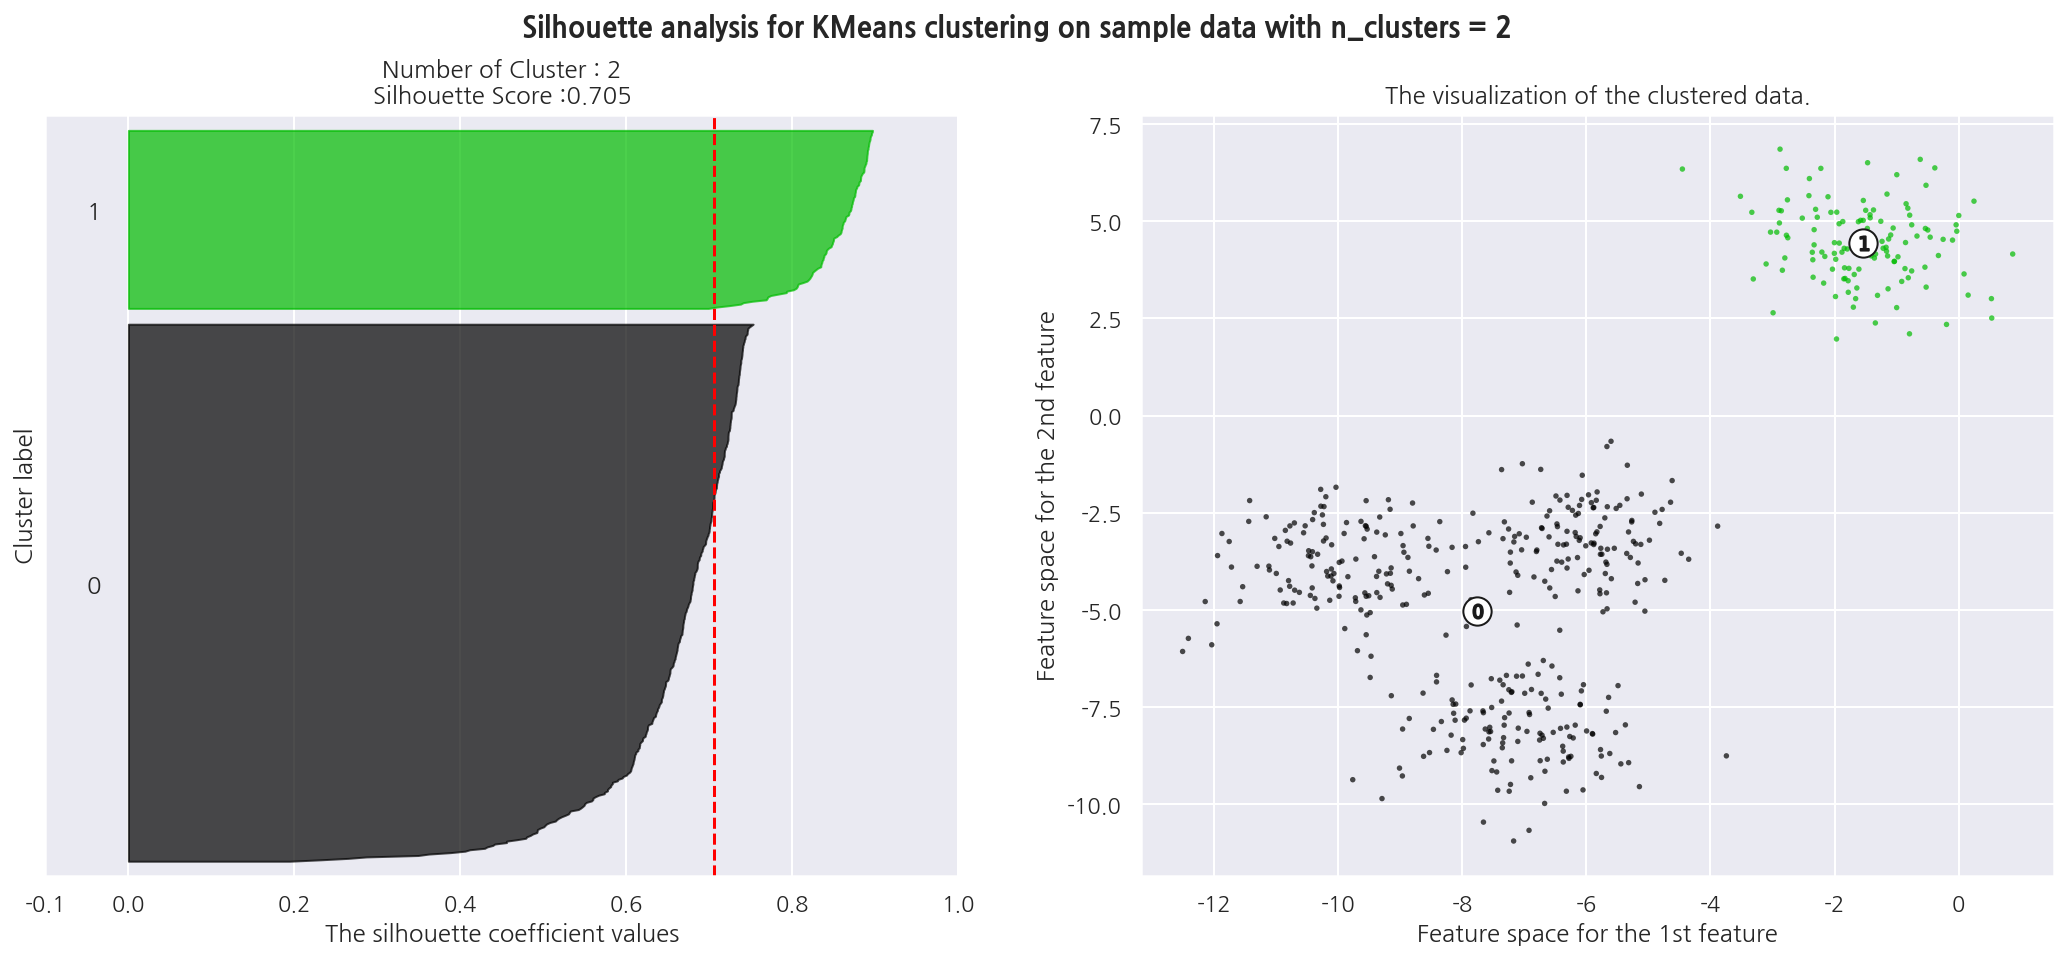

In [6]:
# 가상데이터: 피처 2개, 클러스터 4개
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=500, n_features=2, centers=4, cluster_std=1, 
                  center_box=(-10.0, 10.0), shuffle=True, random_state=1)

# K-Means K: 2
visualize_silhouette_sklearn([2], X)

- 왼쪽 그림의 x축은 실루엣 계수를 의미하며 y축은 개별 데이터 포인트로 Cluster를 구분해두었다.


- 빨간 점선은 전체 데이터의 실루엣 계수 평균이다.


- K를 2로 설정하였을 때 전체 실루엣 계수 평균은 0.705로 높지만 Cluster 0의 실루엣 계수는 대부분 평균에 못 미친다.


- 오른쪽 그림을 보면 Cluster 0은 내부 데이터끼리 거리가 멀리 있음을 알 수 있다.

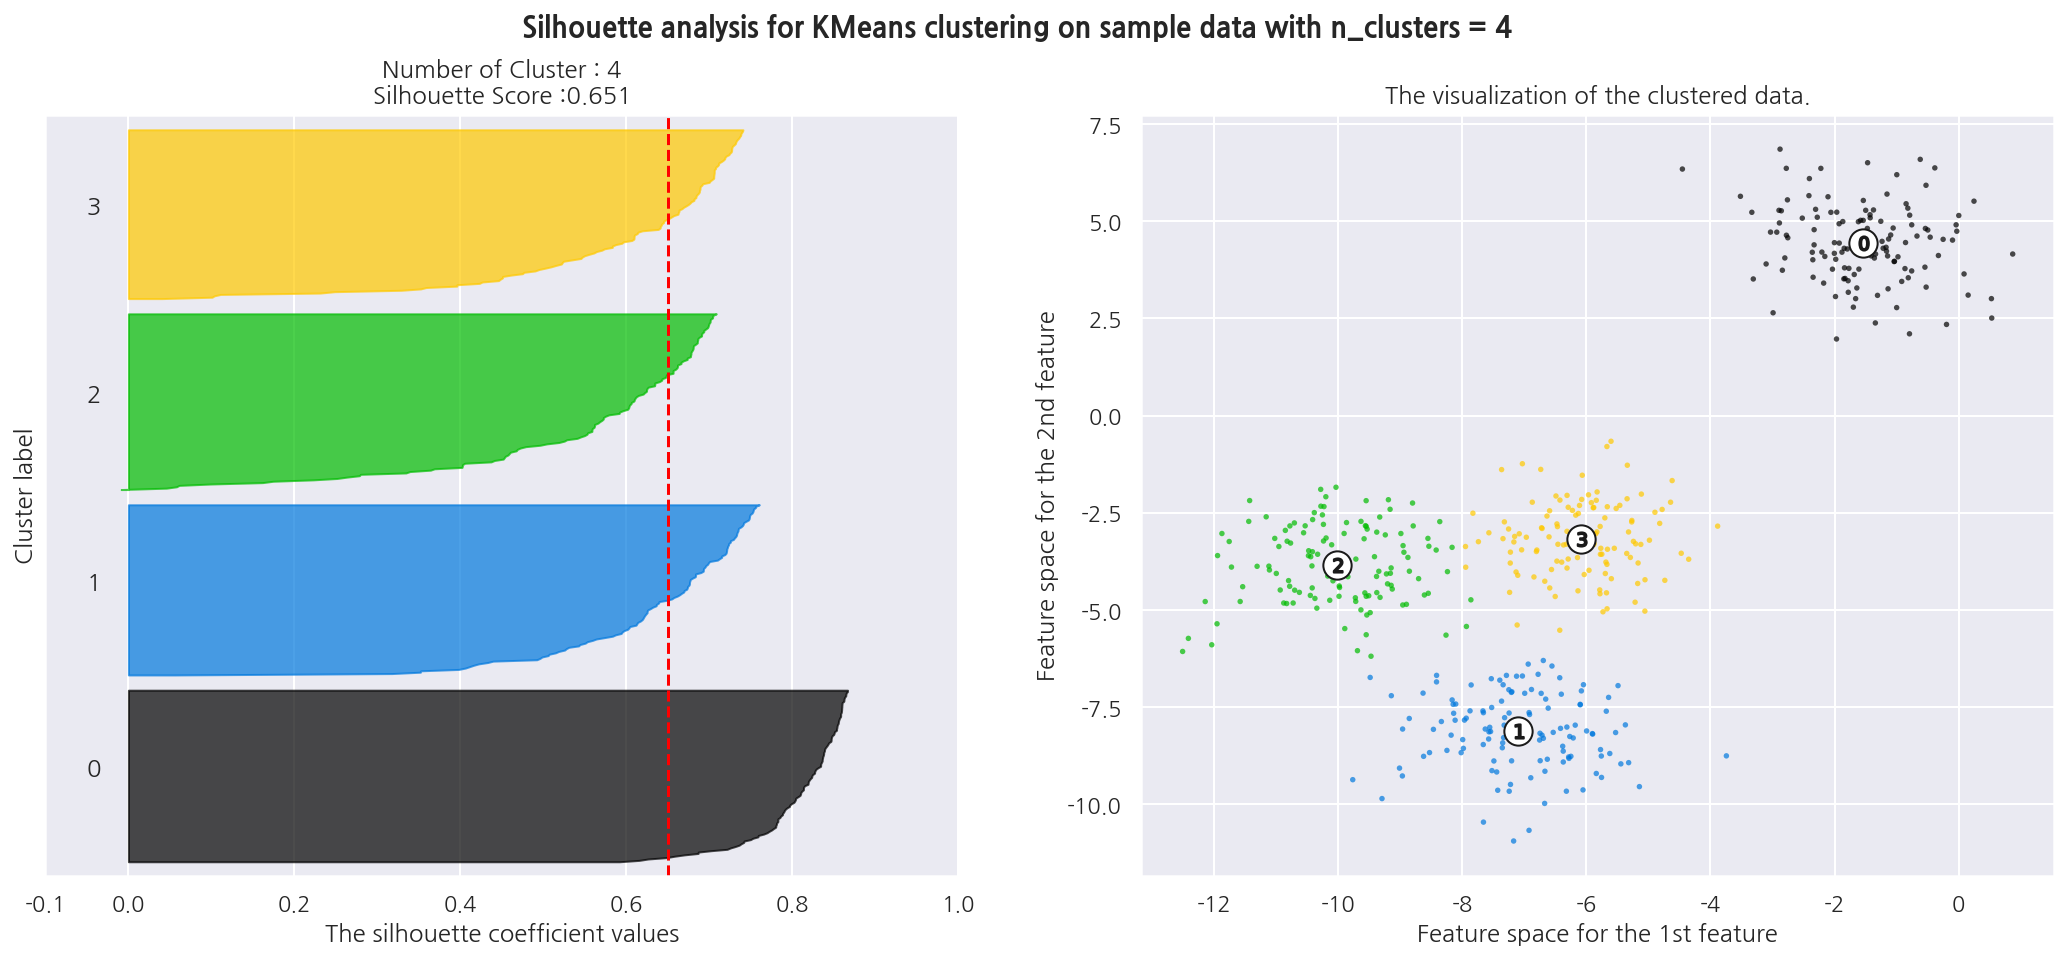

In [7]:
# K-Means K: 4
visualize_silhouette_sklearn([4], X)

- K를 4로 설정하였을 떄 전체 실루엣 계수 평균은 0.651이고, Cluster별로 실루엣 계수가 비교적 균일하다.


- K가 2인 경우보다 전체 실루엣 계수 평균이 작지만 이상적인 군집화 개수로 판단된다.


- 여기선 그림이 많아져서 K는 2,4인 경우만 그려보았다.

**실루엣 계수 시각화 함수2**

앞서 사이킷런의 소스코드를 커스터마이징해서 왼쪽 그림만 나타낸 [교재 소스코드](https://github.com/wikibook/ml-definitive-guide/blob/master/7%EC%9E%A5/7-2_Cluster%20evaluation.ipynb)를 사용해본다.

In [8]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

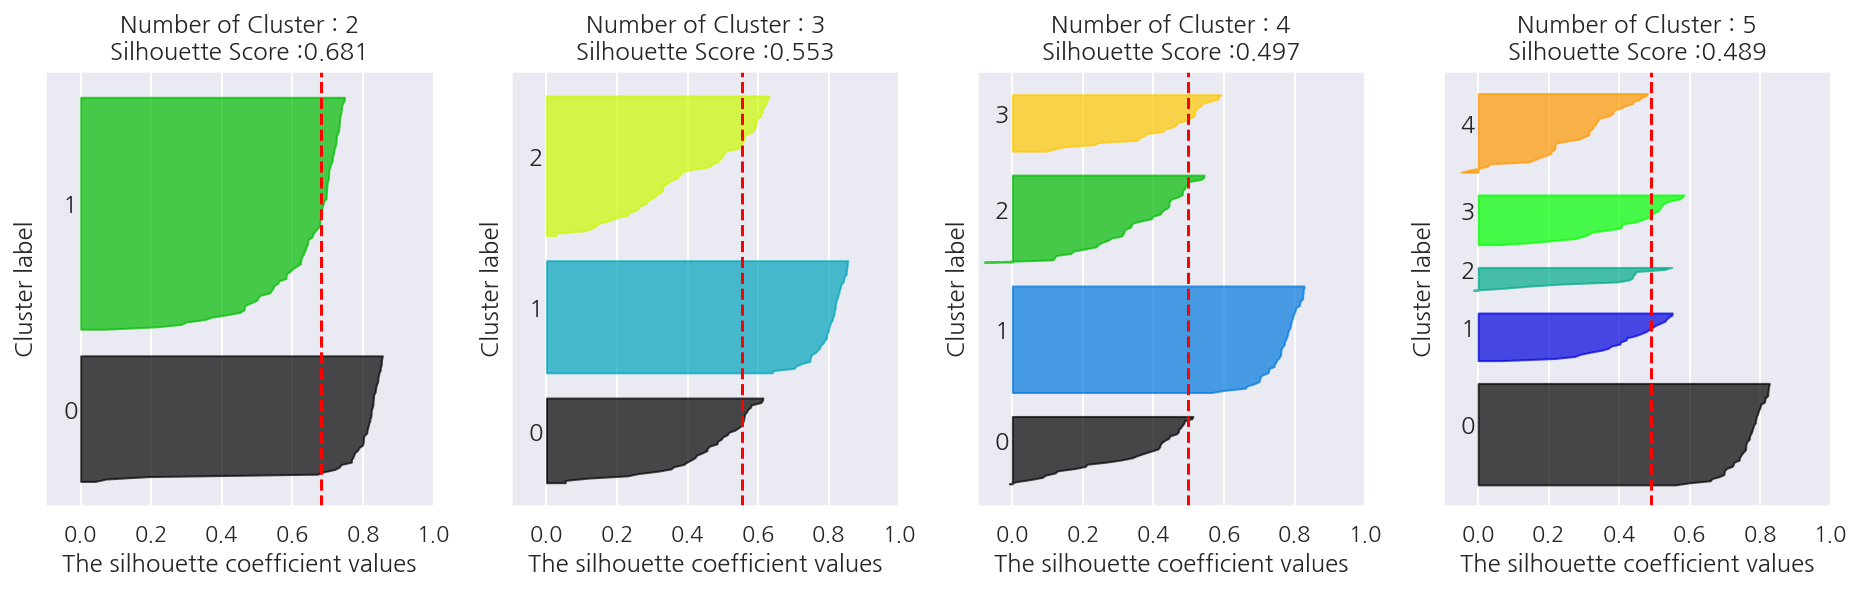

In [9]:
# iris 군집 개수 최적화
visualize_silhouette([ 2, 3, 4,5 ], iris.data)

- IRIS 데이터의 경우는 군집을 2개로 설정하는 것이 좋아보인다.


- 전체 실루엣 계수 평균이 가장 높고, 각 군집별 실루엣 계수 평균도 비교적 균일하다.